In [1]:
import numpy as np
import os
import pickle
import scipy.io
from collections import OrderedDict
from collections import defaultdict
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
class EelEnv:
    def __init__(self, data_folder):
        self.data_folder = data_folder
        self.trial_files = sorted([f for f in os.listdir(data_folder) if f.endswith('.mat')])
        self.current_trial_idx = -1
        self.trial_data = None
        self.total_reward = 0
        self.eels_info = []
        self.load_next_trial()

    def load_next_trial(self):
        self.current_trial_idx += 1
        if self.current_trial_idx >= len(self.trial_files):
            self.trial_data = None
            self.eels_info = []
            return False

        filepath = os.path.join(self.data_folder, self.trial_files[self.current_trial_idx])
        mat = scipy.io.loadmat(filepath, squeeze_me=True)
        curr_trial_data = mat['curr_trial_data']

        self.trial_data = curr_trial_data
        eel_field = curr_trial_data['eels']

        if isinstance(eel_field, np.ndarray) and eel_field.dtype == object:
            eel_tuples = eel_field.tolist()
        else:
            eel_tuples = [eel_field]

        self.eels_info = []
        for eel in eel_tuples:
            eel_dict = {
                'idx': eel[0],
                'side': eel[1],  # 1 = left, 2 = right
                'color': eel[2],
                'pos': eel[3],
                'fish_pos': eel[4],
                'potent': eel[5],
                'comp_change': eel[6],
                'dist_params': eel[7],
                'competency': eel[8],
                'final_competency': eel[9],
                'reliability': eel[10],
            }
            self.eels_info.append(eel_dict)
            
        return True
    
    def color_name(self, rgb):
        if list(rgb) == [0, 0, 255]:
            return "Blue"
        elif list(rgb) == [157, 0, 255]:
            return "Purple"
        else:
            return f"RGB{list(rgb)}"
    
    def step(self, action):
        if self.trial_data is None or not self.eels_info:
            return None, True, {}
        
        # Find index of left eel and right eel in eels_info
        left_idx = next(i for i, eel in enumerate(self.eels_info) if eel['side'] == 1)
        right_idx = next(i for i, eel in enumerate(self.eels_info) if eel['side'] == 2)

        # Map action 0 to left eel, 1 to right eel
        chosen_idx = left_idx if action == 0 else right_idx
        chosen_eel = self.eels_info[chosen_idx]

        # Print info of both eels
        left_eel = self.eels_info[left_idx]
        right_eel = self.eels_info[right_idx]
        
        #print(f"Trial {self.current_trial_idx + 1}:")
        #for i, eel in enumerate(self.eels_info):
            #side_str = 'left' if eel['side'] == 1 else 'right'
            #print(f"Eel {i} info:")
            #print(f"  Side: {side_str}")
            #print(f"  Color: {self.color_name(eel['color'])}")
            #print(f"  Competency: {eel['competency']:.3f}")
            #print(f"  Reliability: {eel['reliability']:.3f}")

        comp = chosen_eel['competency']
        prob_fish_caught = np.array([
            (1 - comp) ** 3,
            3 * comp * (1 - comp) ** 2,
            3 * comp ** 2 * (1 - comp),
            comp ** 3
        ])
        prob_fish_caught /= prob_fish_caught.sum()

        num_fish_caught = np.random.choice([0, 1, 2, 3], p=prob_fish_caught)
        reward_prob = chosen_eel['reliability'] * num_fish_caught
        reward = int(np.random.rand() < reward_prob)

        #print("---------------------------------------------------------")
        #print(f"Chosen eel side: {'left' if chosen_eel['side'] == 1 else 'right'}")
        #print(f"Chosen eel color: {self.color_name(chosen_eel['color'])}")
        #print(f"Number of fish caught: {num_fish_caught}")
        #print(f"Reward probability (reliability × fish caught): {reward_prob:.3f}")
        #print(f"Reward delivered: {reward}")
        #print("---------------------------------------------------------")
        #print(f"Cumulative reward: {self.total_reward + reward}\n")

        info = {
            'chosen_side': 'left' if chosen_eel['side'] == 1 else 'right',
            'eel_color': chosen_eel['color'],
            'competency': comp,
            'reliability': chosen_eel['reliability'],
            'num_fish_caught': num_fish_caught,
            'reward_prob': reward_prob
        }

        done = not self.load_next_trial()
        self.total_reward += reward

        return reward, done, info

In [3]:
class QLearningAgent:
    def __init__(self, n_actions=2, alpha=0.1, gamma=0.9, epsilon=0.2, max_q_entries=10):
        self.q_table = OrderedDict()  # keep insertion order for culling old states
        self.alpha = alpha            # learning rate
        self.gamma = gamma            # discount factor
        self.epsilon = epsilon        # exploration rate
        self.n_actions = n_actions
        self.max_q_entries = max_q_entries
        self.experience_buffer = []   # store transitions for batch update

    def choose_action(self, state_key):
        # Initialize Q-values for unseen states
        if state_key not in self.q_table:
            if len(self.q_table) >= self.max_q_entries:
                self.q_table.popitem(last=False)  # remove oldest state to keep size manageable
            self.q_table[state_key] = [0.0] * self.n_actions
        
        # Epsilon-greedy action selection
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.n_actions)
        else:
            return int(np.argmax(self.q_table[state_key]))

    def store_experience(self, state_key, action, reward, next_state_key):
        self.experience_buffer.append((state_key, action, reward, next_state_key))

    def update(self):
        for (state_key, action, reward, next_state_key) in self.experience_buffer:
            # Add state_key if missing
            if state_key not in self.q_table:
                if len(self.q_table) >= self.max_q_entries:
                    self.q_table.popitem(last=False)
                self.q_table[state_key] = [0.0] * self.n_actions

            if next_state_key is None:
                old_value = self.q_table[state_key][action]
                new_value = old_value + self.alpha * (reward - old_value)
            else:
                # Add next_state_key if missing
                if next_state_key not in self.q_table:
                    if len(self.q_table) >= self.max_q_entries:
                        self.q_table.popitem(last=False)
                    self.q_table[next_state_key] = [0.0] * self.n_actions

                old_value = self.q_table[state_key][action]
                next_max = max(self.q_table[next_state_key])
                new_value = old_value + self.alpha * (reward + self.gamma * next_max - old_value)

            self.q_table[state_key][action] = new_value

        self.experience_buffer = []  # Clear buffer after batch update

In [4]:
def save_checkpoint(agent, cumulative_rewards, trial_idx, episode_num):
    checkpoint_dir = "checkpoints"
    os.makedirs(checkpoint_dir, exist_ok=True)

    checkpoint = {
        'Q_table': agent.q_table,
        'cumulative_rewards': cumulative_rewards,
        'trial_idx': trial_idx,
        'episode_num': episode_num
    }

    filename = f"episode{episode_num}_trial{trial_idx}.pkl"
    save_path = os.path.join(checkpoint_dir, filename)
    with open(save_path, 'wb') as f:
        pickle.dump(checkpoint, f)

    print(f"[Checkpoint] Saved to {save_path}")

def load_checkpoint(agent, episode_num):
    checkpoint_dir = "checkpoints"
    prev_episode = episode_num - 1
    if prev_episode < 1:
        return [], 0  # No previous episode to load from

    checkpoint_file = os.path.join(checkpoint_dir, f"episode{prev_episode}_trial300.pkl")
    if not os.path.exists(checkpoint_file):
        print(f"[Checkpoint] No checkpoint found for episode {prev_episode}")
        return [], 0

    with open(checkpoint_file, 'rb') as f:
        checkpoint = pickle.load(f)
        agent.q_table = checkpoint.get('Q_table', {})
        cumulative_rewards = checkpoint.get('cumulative_rewards', [])
        trial_idx = checkpoint.get('trial_idx', 0)
        print(f"[Checkpoint] Loaded from {checkpoint_file}")
        return cumulative_rewards, trial_idx

In [8]:
train_log = {}
episode_num = 2

env = EelEnv(data_folder=f'premade_eels/train/episode{episode_num}')
agent = QLearningAgent()

# Load checkpoint if available
cumulative_rewards, start_trial = load_checkpoint(agent, episode_num)

# === Episode-specific variables ===
trial_log = []  # Store (state, action, reward, color, side) per trial
cumulative_rewards = []  # Reset for this episode
total_reward = 0         # Reset total reward for episode

color_choices_per_bin = [] 
left_choices, right_choices = [], []
batch_transitions = []

for trial_idx in range(start_trial, len(env.trial_files)):
    
    left_idx = next(i for i, eel in enumerate(env.eels_info) if eel['side'] == 1)
    right_idx = next(i for i, eel in enumerate(env.eels_info) if eel['side'] == 2)

    state = (
        round(env.eels_info[left_idx]['competency'], 2),
        round(env.eels_info[left_idx]['reliability'], 2),
        round(env.eels_info[right_idx]['competency'], 2),
        round(env.eels_info[right_idx]['reliability'], 2),
    )

    action = agent.choose_action(state)
    reward, done, info = env.step(action)
    color = env.color_name(info['eel_color'])
    
    # Save to trial log
    trial_log.append((state, action, reward, color, info['chosen_side']))
    
    if not done:
        next_left_idx = next(i for i, eel in enumerate(env.eels_info) if eel['side'] == 1)
        next_right_idx = next(i for i, eel in enumerate(env.eels_info) if eel['side'] == 2)
        next_state = (
            round(env.eels_info[next_left_idx]['competency'], 2),
            round(env.eels_info[next_left_idx]['reliability'], 2),
            round(env.eels_info[next_right_idx]['competency'], 2),
            round(env.eels_info[next_right_idx]['reliability'], 2),
        )
    else:
        next_state = None
        
    # Store for batch update
    batch_transitions.append((state, action, reward, next_state))
    total_reward += reward

    # Count choices per 10-trial bin
    bin_idx = trial_idx // 10
    
    while len(color_choices_per_bin) <= bin_idx:
        color_choices_per_bin.append(defaultdict(int))
        
    color_choices_per_bin[bin_idx][color] += 1
    
    while len(left_choices) <= bin_idx:
        left_choices.append(0)
        right_choices.append(0)

    if action == 0:
        left_choices[bin_idx] += 1
    else:
        right_choices[bin_idx] += 1

    # Save cumulative reward per trial (not averaged)
    cumulative_rewards.append(total_reward)

    # Batch update every 10 trials or at last trial
    if (trial_idx + 1) % 10 == 0 or (trial_idx + 1) == len(env.trial_files):
        # Store experiences in the agent's buffer
        for s, a, r, s_next in batch_transitions:
            agent.store_experience(s, a, r, s_next)
    
        # Update Q-table in batch
        agent.update()
    
        batch_transitions = []  # Clear batch

        # Save checkpoint every batch update (optional, can save less frequently)
        save_checkpoint(agent, cumulative_rewards, trial_idx + 1, episode_num)

        
# === After the episode finishes ===
# Save the trial log for this episode
train_log[episode_num] = trial_log

# Save all logs to a .pkl file (append or update)
log_dir = "train_log"
os.makedirs(log_dir, exist_ok=True)
log_path = os.path.join(log_dir, f"episode{episode_num}_log.pkl")

# Load existing log if it exists
if os.path.exists(log_path):
    with open(log_path, 'rb') as f:
        existing_log = pickle.load(f)
else:
    existing_log = {}

# Update with current episode log
existing_log[episode_num] = trial_log

# Save back to file
with open(log_path, 'wb') as f:
    pickle.dump(existing_log, f)

[Checkpoint] Loaded from checkpoints\episode1_trial300.pkl


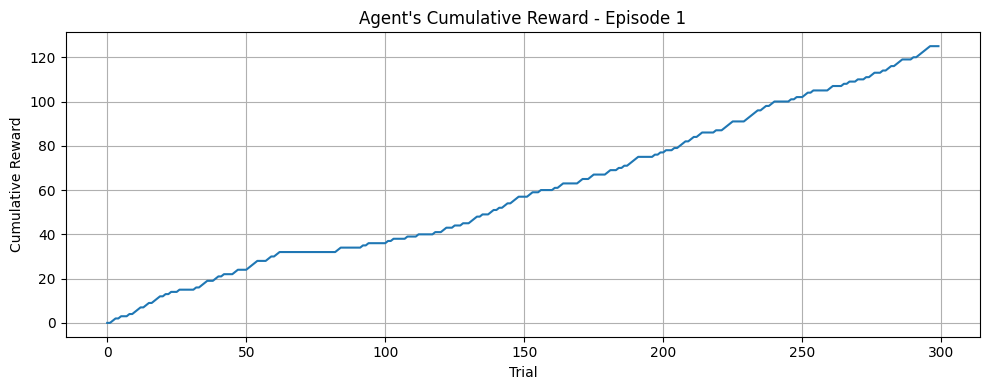

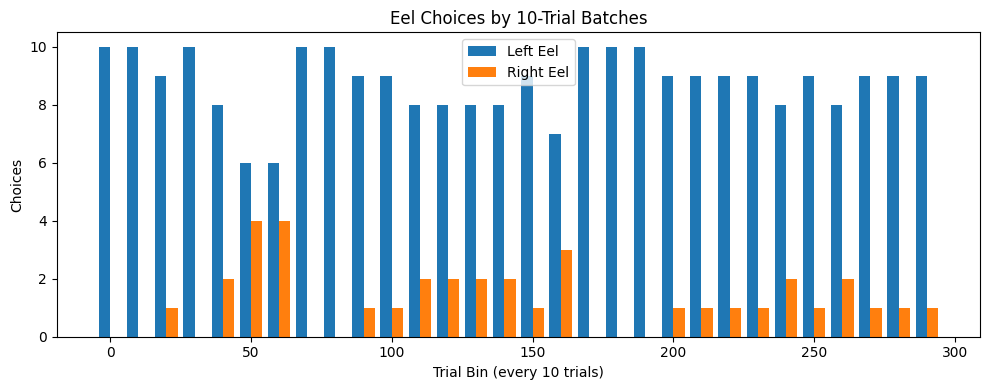

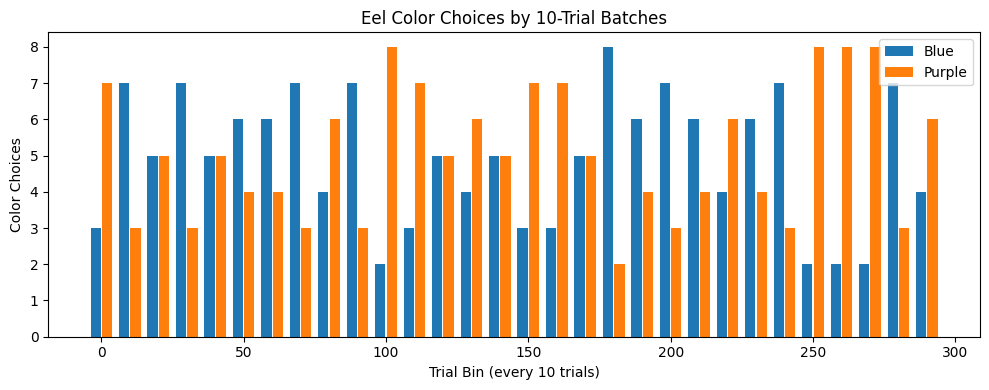

In [7]:
# ===== Plotting Section =====

# 1. Cumulative Reward Plot
plt.figure(figsize=(10, 4))
plt.plot(cumulative_rewards, label="Cumulative Reward")
plt.xlabel("Trial")
plt.ylabel("Cumulative Reward")
plt.title(f"Agent's Cumulative Reward - Episode {episode_num}")
plt.grid(True)
plt.tight_layout()
plt.show()
plt.close()

# 2. Choice Frequency Plot (per 10 trials)
x = np.arange(len(left_choices)) * 10  # trial bins
width = 4

plt.figure(figsize=(10, 4))
plt.bar(x - width/2, left_choices, width=width, label='Left Eel')
plt.bar(x + width/2, right_choices, width=width, label='Right Eel')
plt.xlabel("Trial Bin (every 10 trials)")
plt.ylabel("Choices")
plt.title("Eel Choices by 10-Trial Batches")
plt.legend()
plt.tight_layout()
plt.show()
plt.close()

# 3. Color coded Plot 
# Collect unique colors (sorted for consistent order)
all_colors = sorted(set(color for counter in color_choices_per_bin for color in counter))
num_colors = len(all_colors)
num_bins = len(color_choices_per_bin)
x = np.arange(num_bins) * 10  # trial bins

width = 4  # Same as in your left/right plot
total_width = width * num_colors
bar_spacing = width  # spacing between color bars

plt.figure(figsize=(10,4))

# Each color gets its own offset in the bin
for i, color in enumerate(all_colors):
    counts = [counter.get(color, 0) for counter in color_choices_per_bin]
    offsets = x - (total_width / 2) + (i + 0.5) * bar_spacing
    plt.bar(offsets, counts, width=bar_spacing * 0.9, label=color)  # slight shrink for spacing

plt.xlabel("Trial Bin (every 10 trials)")
plt.ylabel("Color Choices")
plt.title("Eel Color Choices by 10-Trial Batches")
plt.legend()
plt.tight_layout()
plt.show()
plt.close()